In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from __future__ import print_function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import shutil

In [2]:
# %cd ..
# %cd ..
# shutil.rmtree('EVA8')

In [3]:
!git clone https://github.com/shreyash-99/EVA8.git
%cd EVA8/EVA8-all_models-new
from utils import *
from main import *

fatal: destination path 'EVA8' already exists and is not an empty directory.
/content/EVA8/EVA8-all_models-new


In [4]:
%ls

data/  main.py  models/  __pycache__/  utils.py


In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
BATCH_SIZE = 512
train_data_lrfinder = torch.utils.data.DataLoader(Albumentation_cifar_Dataset(testset, train=False), batch_size=128,
                                          shuffle=False)
train_loader = torch.utils.data.DataLoader(Albumentation_cifar_Dataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(Albumentation_cifar_Dataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

In [7]:
info_about_dataset(trainset)

[Train
 - Numpy Shape: (50000, 32, 32, 3)
 - min: [0. 0. 0.]
 - max: [1. 1. 1.]
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
 - var: [15.56135559 15.11767693 17.44919073]


In [8]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')


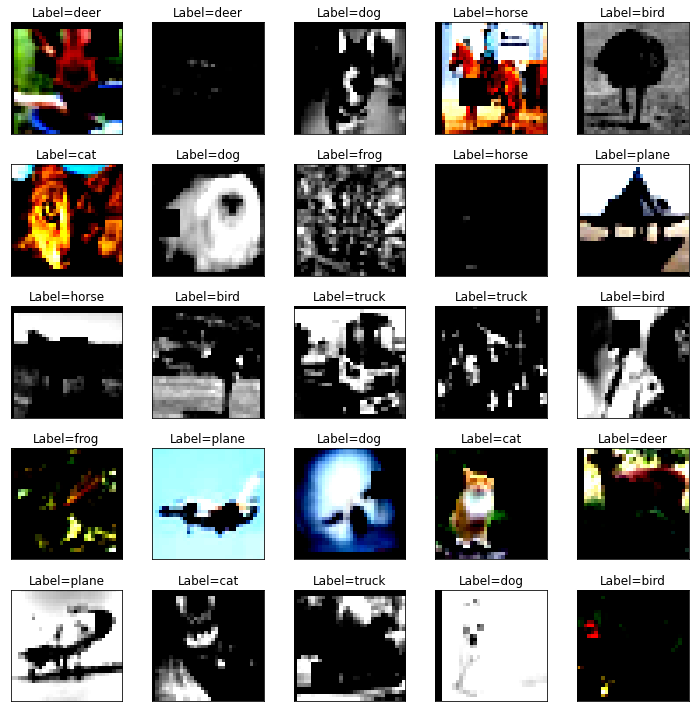

In [9]:
visualize_augmented_images(train_loader, classes, 5,5)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

#depthwise separable convolution
class BasicBlock(nn.Module):
    expansion = 1
  
    def __init__(self, in_ch, out_ch, stride=1):
        super(BasicBlock, self).__init__()
        self.in_chan = in_ch
        self.out_chan = out_ch

        self.conv1 = nn.Conv2d(self.in_chan, self.out_chan, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.out_chan)
        self.conv2 = nn.Conv2d(self.out_chan, self.out_chan, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.out_chan)

        self.shortcut = nn.Sequential()
        if stride != 1 or self.in_chan != self.expansion*self.out_chan:
            self.shortcut = nn.Sequential(
                nn.Conv2d(self.in_chan, self.expansion*self.out_chan, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*self.out_chan)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class custom_ResNet(nn.Module):
    def __init__(self):
        super(custom_ResNet, self).__init__()
        ### input = 32*32 , output = 32*32 , out channels = 32
        self.prep = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64,  kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        #### input = 32* 32, output = 16 * 16
        self.Layer1_part1 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, stride = 1, padding = 1, kernel_size = 3, bias = False),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.Layer1_part2 = nn.Sequential(
            BasicBlock(64, 128, 2)
        )

        ##### input = 16 * 16 output = 8 * 8
        self.Layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )   

        #### input = 8 * 8 output = 4 * 4
        self.Layer3_part1 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.MaxPool2d(kernel_size = 2, stride =2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) 
        self.Layer3_part2 = nn.Sequential(
            BasicBlock(256,512,2)
        )

        #### input = 4 * 4 * 512 --> 1 * 1 * 512 --> 512 --> 10
        self.maxpool = nn.MaxPool2d(kernel_size = 4)
        self.fc = nn.Linear(in_features = 512, out_features = 10, bias = False)


    def forward(self, x):
        x = self.prep(x)
        x1 = self.Layer1_part1(x)
        x2 = self.Layer1_part2(x)
        x = x1 + x2
        x = self.Layer2(x)
        x3 = self.Layer3_part1(x)
        x4 = self.Layer3_part2(x)
        x = x4 + x3
        x = self.maxpool(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        return x

In [18]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = custom_ResNet()
model = model.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]           8,192
      BatchNorm2d-13          [-1, 128, 16, 16]             256
       BasicBlock-14          [-1,

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.93E-02


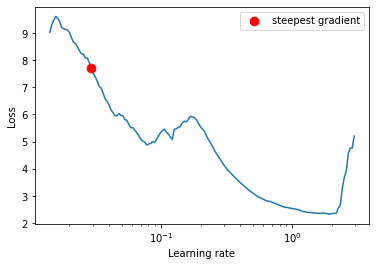

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.02933166278390045)

In [19]:
!pip install torch_lr_finder
from torch_lr_finder import LRFinder
import copy

# model = custom_ResNet().to(device)
model_exp = copy.deepcopy(model)

optimizer = torch.optim.SGD(model_exp.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model_exp, optimizer, criterion, device=device)
lr_finder.range_test(train_data_lrfinder, end_lr=10, num_iter=200)
lr_finder.plot()

In [20]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 1.956398343517064


In [21]:
# model_new = custom_ResNet().to(device)
from torch.optim.lr_scheduler import StepLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr= 0.01,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=20,
                                                three_phase=False, 
                                                final_div_factor=50,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,

In [22]:
net, history = fit_model(
    net=model, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=train_loader, test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.0005)


Batch_id=97 Loss=2.01140 Accuracy=32.29%: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]



Test set: Average loss: 1.4660, Accuracy: 4578/10000 (45.78%)

EPOCH: 2 (LR: 0.0024833830421815083)


Batch_id=97 Loss=1.36325 Accuracy=51.34%: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]



Test set: Average loss: 1.1558, Accuracy: 5902/10000 (59.02%)

EPOCH: 3 (LR: 0.004466766084363017)


Batch_id=97 Loss=1.35993 Accuracy=55.56%: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]



Test set: Average loss: 1.3562, Accuracy: 5364/10000 (53.64%)

EPOCH: 4 (LR: 0.006450149126544524)


Batch_id=97 Loss=1.10441 Accuracy=62.06%: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]



Test set: Average loss: 1.2522, Accuracy: 6286/10000 (62.86%)

EPOCH: 5 (LR: 0.008433532168726034)


Batch_id=97 Loss=1.04511 Accuracy=65.16%: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]



Test set: Average loss: 0.9732, Accuracy: 6846/10000 (68.46%)

EPOCH: 6 (LR: 0.009890628188775511)


Batch_id=97 Loss=0.85558 Accuracy=70.81%: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]



Test set: Average loss: 0.9076, Accuracy: 6920/10000 (69.20%)

EPOCH: 7 (LR: 0.009370315688775511)


Batch_id=97 Loss=0.76586 Accuracy=73.60%: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]



Test set: Average loss: 0.6354, Accuracy: 7816/10000 (78.16%)

EPOCH: 8 (LR: 0.008850003188775511)


Batch_id=97 Loss=0.70209 Accuracy=75.73%: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]



Test set: Average loss: 0.6743, Accuracy: 7750/10000 (77.50%)

EPOCH: 9 (LR: 0.00832969068877551)


Batch_id=97 Loss=0.63880 Accuracy=78.04%: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]



Test set: Average loss: 0.5555, Accuracy: 8137/10000 (81.37%)

EPOCH: 10 (LR: 0.0078093781887755105)


Batch_id=97 Loss=0.59750 Accuracy=79.31%: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]



Test set: Average loss: 0.5751, Accuracy: 8082/10000 (80.82%)

EPOCH: 11 (LR: 0.0072890656887755105)


Batch_id=97 Loss=0.56461 Accuracy=80.40%: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]



Test set: Average loss: 0.5678, Accuracy: 8067/10000 (80.67%)

EPOCH: 12 (LR: 0.006768753188775511)


Batch_id=97 Loss=0.52110 Accuracy=82.05%: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]



Test set: Average loss: 0.5637, Accuracy: 8097/10000 (80.97%)

EPOCH: 13 (LR: 0.00624844068877551)


Batch_id=97 Loss=0.50979 Accuracy=82.38%: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]



Test set: Average loss: 0.5029, Accuracy: 8307/10000 (83.07%)

EPOCH: 14 (LR: 0.005728128188775511)


Batch_id=97 Loss=0.47564 Accuracy=83.44%: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]



Test set: Average loss: 0.6392, Accuracy: 7980/10000 (79.80%)

EPOCH: 15 (LR: 0.005207815688775511)


Batch_id=97 Loss=0.44470 Accuracy=84.63%: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]



Test set: Average loss: 0.4938, Accuracy: 8324/10000 (83.24%)

EPOCH: 16 (LR: 0.00468750318877551)


Batch_id=97 Loss=0.41568 Accuracy=85.50%: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]



Test set: Average loss: 0.5014, Accuracy: 8391/10000 (83.91%)

EPOCH: 17 (LR: 0.00416719068877551)


Batch_id=97 Loss=0.39968 Accuracy=86.01%: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]



Test set: Average loss: 0.4563, Accuracy: 8494/10000 (84.94%)

EPOCH: 18 (LR: 0.00364687818877551)


Batch_id=97 Loss=0.37666 Accuracy=86.99%: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]



Test set: Average loss: 0.4429, Accuracy: 8544/10000 (85.44%)

EPOCH: 19 (LR: 0.00312656568877551)


Batch_id=97 Loss=0.36112 Accuracy=87.60%: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]



Test set: Average loss: 0.4406, Accuracy: 8557/10000 (85.57%)

EPOCH: 20 (LR: 0.0026062531887755093)


Batch_id=97 Loss=0.34320 Accuracy=88.22%: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]



Test set: Average loss: 0.4189, Accuracy: 8608/10000 (86.08%)

EPOCH: 21 (LR: 0.0020859406887755103)


Batch_id=97 Loss=0.32205 Accuracy=88.95%: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]



Test set: Average loss: 0.4260, Accuracy: 8585/10000 (85.85%)

EPOCH: 22 (LR: 0.0015656281887755103)


Batch_id=97 Loss=0.30621 Accuracy=89.59%: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]



Test set: Average loss: 0.4057, Accuracy: 8659/10000 (86.59%)

EPOCH: 23 (LR: 0.0010453156887755104)


Batch_id=97 Loss=0.29418 Accuracy=90.00%: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]



Test set: Average loss: 0.3887, Accuracy: 8725/10000 (87.25%)

EPOCH: 24 (LR: 0.0005250031887755104)


Batch_id=97 Loss=0.27835 Accuracy=90.59%: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]



Test set: Average loss: 0.3839, Accuracy: 8734/10000 (87.34%)

